## About
Binary image segmentation using a U-net to predict where the car is in the image.

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import pathlib
import torch

In [3]:
import fastai
from fastai.vision import *
#from fastai.callbacks import *

## Data

In [4]:
path = pathlib.Path.home()/'.fastai/data/carvana-image-masking-challenge'

In [5]:
! mkdir -p $path;
! kaggle competitions download -c carvana-image-masking-challenge -f train.zip -p $path
! kaggle competitions download -c carvana-image-masking-challenge -f train_masks.zip -p $path
! kaggle competitions download -c carvana-image-masking-challenge -f train_masks.csv.zip -p $path
! kaggle competitions download -c carvana-image-masking-challenge -f test.zip -p $path

! cd $path; if [ ! -d train ]; then unzip -n -q train.zip; fi
! cd $path; if [ ! -d train_masks ]; then unzip -n -q train_masks.zip; fi
! cd $path; if [ ! -f train_masks.csv ]; then unzip -n -q train_masks.csv.zip; fi
! cd $path; if [ ! -d test ]; then unzip -n -q test.zip; fi

train.zip: Skipping, found more recently modified local copy (use --force to force download)
train_masks.zip: Skipping, found more recently modified local copy (use --force to force download)
train_masks.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
os.listdir(path)

['metadata.csv.zip',
 'train_masks.zip',
 'train_masks.csv.zip',
 'sample_submission.csv.zip',
 'test.zip',
 '29bb3ece3180_11.jpg',
 'train',
 'test',
 'train_masks',
 'train_masks.csv',
 'metadata.csv',
 'sample_submission.csv',
 'train.zip',
 'train_224',
 'train_224_masks']

In [24]:
train_dir = 'train'
train_masks_dir = 'train_masks'

In [25]:
os.listdir(path/train_dir)[:5]

['00087a6bd4dc_01.jpg',
 '00087a6bd4dc_02.jpg',
 '00087a6bd4dc_03.jpg',
 '00087a6bd4dc_04.jpg',
 '00087a6bd4dc_05.jpg']

In [26]:
img_path = path/f'{train_dir}/00087a6bd4dc_01.jpg'

In [27]:
img = open_image(img_path)

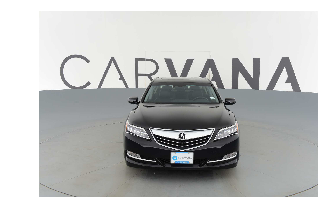

In [28]:
img.show(figsize=(5,5))

In [29]:
img.shape

torch.Size([3, 1280, 1918])

In [30]:
os.listdir(path/train_masks_dir)[:5]

['00087a6bd4dc_01_mask.gif',
 '00087a6bd4dc_02_mask.gif',
 '00087a6bd4dc_03_mask.gif',
 '00087a6bd4dc_04_mask.gif',
 '00087a6bd4dc_05_mask.gif']

In [31]:
def get_y_fn(x):
    fname = str(x.name).replace('.jpg', '_mask.gif')
    return Path(str(x.parent)+f'_masks/{fname}')

In [32]:
mask = open_mask(get_y_fn(img_path))

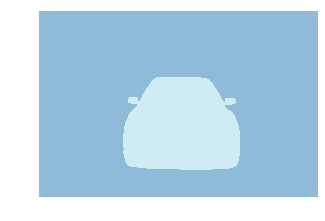

In [33]:
mask.show(figsize=(5,5))

In [34]:
mask.shape

torch.Size([1, 1280, 1918])

## Datasets

In [35]:
bs = 16
num_workers = 6
size = 224

In [36]:
tfms = get_transforms()

In [37]:
# need custom class to set div=True so classes are [0,1] instead of [0,256]
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn):
        return open_mask(fn, div=True)
    
class SegItemListCustom(ImageList):
    _label_cls = SegLabelListCustom

In [38]:
src = (SegItemListCustom.from_folder(path/train_dir)
        .split_by_rand_pct(valid_pct=0.30)
        .label_from_func(get_y_fn, classes=['no', 'yes']))

In [39]:
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

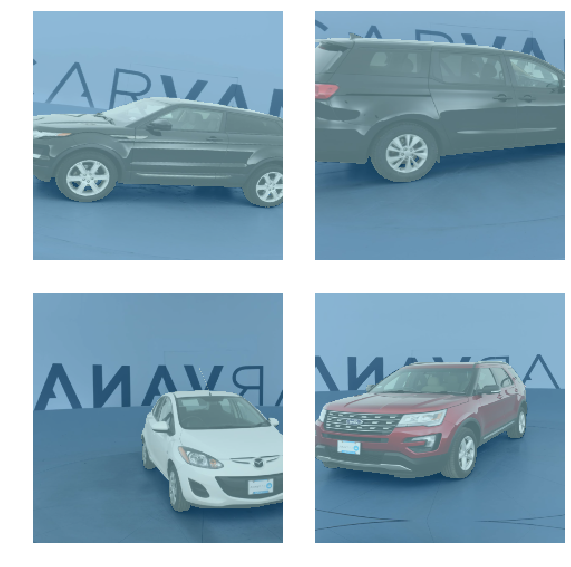

In [40]:
data.show_batch(2, fig_size=(5,5))

In [64]:
data.x

SegItemListCustom (3562 items)
Image (3, 1280, 1918),Image (3, 1280, 1918),Image (3, 1280, 1918),Image (3, 1280, 1918),Image (3, 1280, 1918)
Path: /root/.fastai/data/carvana-image-masking-challenge/train

In [65]:
data.y

SegLabelListCustom (3562 items)
ImageSegment (1, 1280, 1918),ImageSegment (1, 1280, 1918),ImageSegment (1, 1280, 1918),ImageSegment (1, 1280, 1918),ImageSegment (1, 1280, 1918)
Path: /root/.fastai/data/carvana-image-masking-challenge/train

In [66]:
data.c

2

## Model

In [44]:
arch = models.resnet34
wd=1e-2

In [55]:
learn = unet_learner(data, arch, metrics=[dice], wd=wd)

In [56]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________

## Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


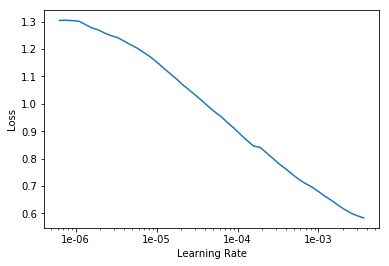

In [57]:
learn.lr_find()
learn.recorder.plot()

In [48]:
lr = 7e-4

In [58]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.027655,0.018015,0.988017,02:37
1,0.014642,0.014085,0.990327,02:42
2,0.011958,0.011589,0.992131,02:43


In [59]:
learn.save('stage-1')

In [60]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


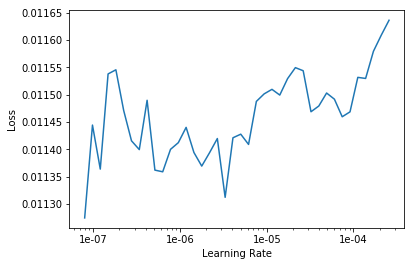

In [62]:
learn.lr_find(start_lr=1e-8)
learn.recorder.plot()

In [63]:
learn.fit_one_cycle(2, max_lr=slice(4e-7, 2e-6))

epoch,train_loss,valid_loss,dice,time
0,0.011635,0.011513,0.992177,02:45
1,0.011488,0.011478,0.992193,02:45


In [ ]:
learn.save('stage-2')

## Results

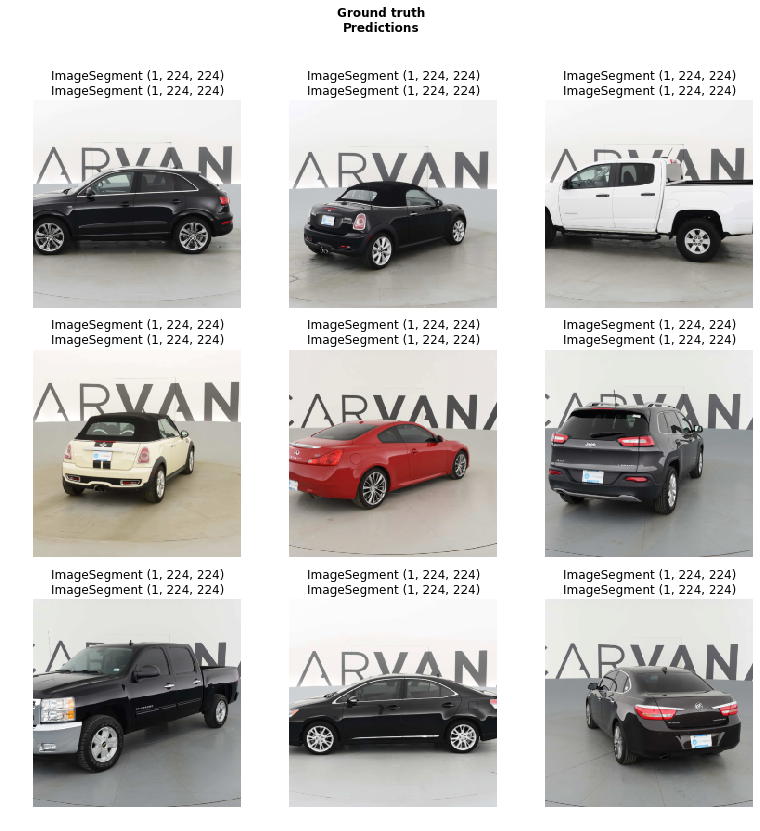

In [50]:
learn.show_results(rows=3, figsize=(13,13))

In [51]:
preds, targs = learn.get_preds()

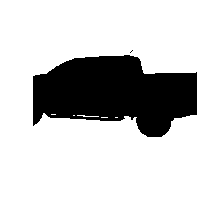

In [52]:
show_image(targs[2])

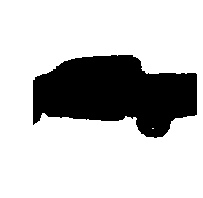

In [53]:
show_image(preds[2].argmax(dim=0).unsqueeze(0))

#### TODOs
- pre resize
- why mask not showing in results?  prob custom classes